In [18]:
import json
import os
import numpy as np

#method_names = ['btwins', 'dc', 'moco', 'simsiam', 'sup', 'swav']
dataset_names = ['Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds', 'ImageNet']
vissl_dir = '/vulcanscratch/mgwillia/vissl'
results = {}
for dataset in dataset_names:
    ## TODO: eventually, compare top-1 to top-5
    results[dataset.lower()] = {}
    for results_folder in os.listdir(vissl_dir):
        if f'chkpts_b_{dataset.lower()}' not in results_folder:
            continue
        if 'metrics.json' not in os.listdir(os.path.join(vissl_dir, results_folder)):
            continue
        method_name = results_folder.split('_')[3]
        idx = int(results_folder.split('_')[4])
        if method_name not in results[dataset.lower()]:
            results[dataset.lower()][method_name] = {
                'train': {},
                'val': {}
            }
        #print(os.path.join(vissl_dir, results_folder, 'metrics.json'))
        with open(os.path.join(vissl_dir, results_folder, 'metrics.json'), 'r') as read_file:
            for line in read_file.readlines():
                json_line = json.loads(line)
                if 'train_accuracy_list_meter' in json_line.keys():
                    for key, value in json_line['train_accuracy_list_meter']['top_1'].items():
                        if key not in results[dataset.lower()][method_name]['train']:
                            results[dataset.lower()][method_name]['train'][key] = {}
                        if idx not in results[dataset.lower()][method_name]['train'][key]:
                            results[dataset.lower()][method_name]['train'][key][idx] = []
                        results[dataset.lower()][method_name]['train'][key][idx].append(value)
                elif 'test_accuracy_list_meter' in json_line.keys():
                    for key, value in json_line['test_accuracy_list_meter']['top_1'].items():
                        if key not in results[dataset.lower()][method_name]['val']:
                            results[dataset.lower()][method_name]['val'][key] = {}
                        if idx not in results[dataset.lower()][method_name]['val'][key]:
                            results[dataset.lower()][method_name]['val'][key][idx] = []
                        results[dataset.lower()][method_name]['val'][key][idx].append(value)
                        
for dataset in results.keys():
    for method in results[dataset].keys():
        for layer in results[dataset][method]['val'].keys():
            accs = []
            for idx in results[dataset][method]['val'][layer].keys():
                accs.append(results[dataset][method]['val'][layer][idx][-1])
            results[dataset][method]['val'][layer]['mean'] = np.mean(accs)
            results[dataset][method]['val'][layer]['std'] = np.std(accs)
print(results['imagenet'].keys())

dict_keys(['btwins', 'supervised', 'moco', 'swav', 'dc', 'sclr', 'simsiam'])


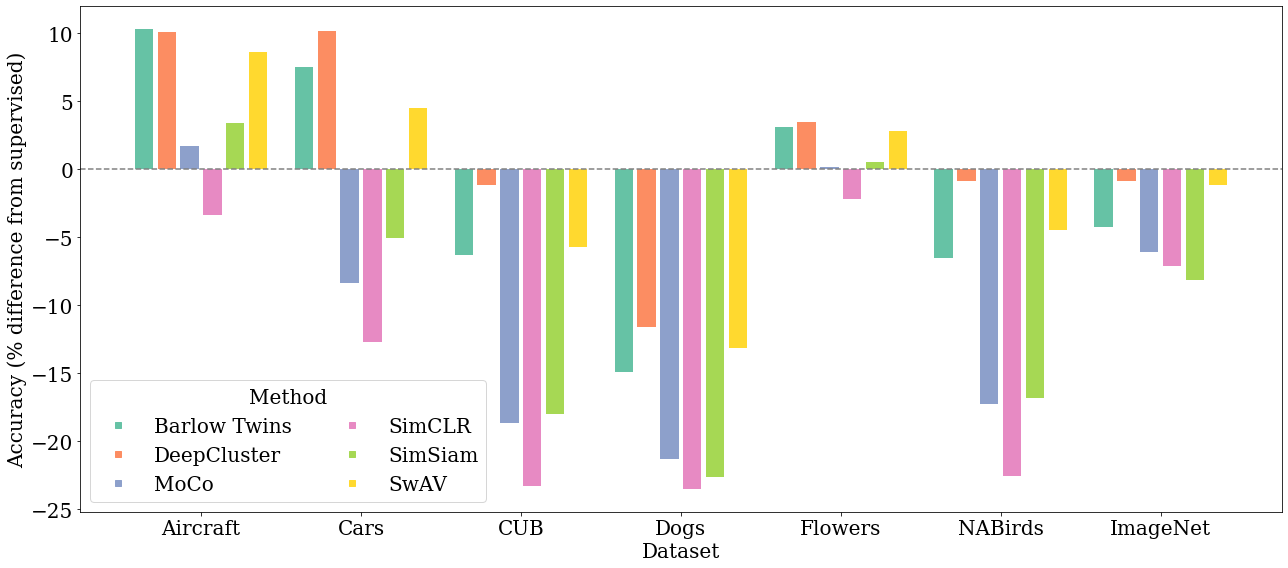

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,8)
cmap = plt.get_cmap('Set2')
plt.rcParams["font.family"] = "serif"
colormap = np.array(list(cmap.colors))

results['imagenet'] = {
    'btwins': {
        'val': {
            'res5': {
                'mean': 71.78
            }
        }
    },
    'dc': {
        'val': {
            'res5': {
                'mean': 75.19
            }
        }
    },
    'moco': {
        'val': {
            'res5': {
                'mean': 69.95
            }
        }
    },
    'sclr': {
        'val': {
            'res5': {
                'mean': 68.95
            }
        }
    },
    'simsiam': {
        'val': {
            'res5': {
                'mean': 67.89
            }
        }
    },
    'sup': {
        'val': {
            'res5': {
                'mean': 76.04 
            }
        }
    },
    'swav': {
        'val': {
            'res5': {
                'mean': 74.87
            }
        }
    }
}

method_names = ['btwins', 'dc', 'moco', 'sclr', 'simsiam', 'swav']

fig, ax = plt.subplots(1, 1)
layer_name = 'res5'
dataset_ids = []
method_ids = []
accuracies = []
for i, dataset_name in enumerate(dataset_names):
    for j, method_name in enumerate(method_names):
        final_accuracy = results[dataset_name.lower()][method_name]['val'][layer_name]['mean']
        #print(results[dataset_name.lower()][method_name]['val'][layer_name]['mean'])
        #print(results[dataset_name.lower()][method_name]['val'][layer_name]['std'])
        dataset_ids.append(i * (len(method_names) + 1) + j + 1)
        method_ids.append(j)
        accuracies.append(final_accuracy - results[dataset_name.lower()]['sup']['val'][layer_name]['mean'])
ax.bar(dataset_ids, accuracies, color=colormap[method_ids])
ax.set_xticks(0.5 + np.array(list(range(3, len(dataset_names) * 7 + 3, 7))))
ax.set_xticklabels(dataset_names, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.axhline(y=0.0, color='gray', linestyle='--')
    
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in range(7)]
ax.legend(handles,
          ['Barlow Twins', 'DeepCluster', 'MoCo', 'SimCLR', 'SimSiam', 'SwAV'],
          title='Method',
          title_fontsize=20,
          scatterpoints=1,
          ncol=2,
          fontsize=20)

#plt.title(f'Linear Classifier Trained on Frozen Features', fontsize=24)
ax.set_xlabel('Dataset', fontsize=20)
ax.set_ylabel('Accuracy (% difference from supervised)', fontsize=20)

fig.tight_layout()
plt.savefig(f'all_frozen_results.pdf', bbox_inches = 'tight',
    pad_inches = 0.1)

In [14]:
### MAKE LIN EVAL TABLE ###
method_names = ['btwins', 'dc', 'moco', 'sclr', 'simsiam', 'sup', 'swav']

method_table_results = {}
for dataset_name, dataset_results in results.items():
    for method_name in method_names:
        method_results = dataset_results[method_name]
        if method_name not in method_table_results:
            method_table_results[method_name] = {}
        method_table_results[method_name][dataset_name.lower()] = method_results['val'][layer_name][-1]
        
datasets = ['ImageNet', 'Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds']
method_print_name = {
    'btwins': 'BTwins',
    'dc': 'DCv2',
    'moco': 'MoCo',
    'sclr': 'SimCLR',
    'simsiam': 'SimSiam',
    'sup': 'Supervised',
    'swav': 'SwAV',
}

print('\\begin{tabular}{l l l l l l l l}')
print('\\multirow{2}{*}{Method} & \\multicolumn{7}{c}{Dataset} \\\\ \\cmidrule{2-8}')
print('{} & \\multicolumn{1}{c}{' + '} & \\multicolumn{1}{c}{'.join(datasets) + '} \\\\')
print('\\midrule')
for method_name, method_results in method_table_results.items():
    accs = []
    for dataset_name in datasets:
        accs.append(f'{method_results[dataset_name.lower()]:.2f}')
    print(f'\t{method_print_name[method_name.split("_")[0]]} & {" & ".join(accs)} \\\\')
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{l l l l l l l l}
\multirow{2}{*}{Method} & \multicolumn{7}{c}{Dataset} \\ \cmidrule{2-8}
{} & \multicolumn{1}{c}{ImageNet} & \multicolumn{1}{c}{Aircraft} & \multicolumn{1}{c}{Cars} & \multicolumn{1}{c}{CUB} & \multicolumn{1}{c}{Dogs} & \multicolumn{1}{c}{Flowers} & \multicolumn{1}{c}{NABirds} \\
\midrule
	BTwins & 71.78 & 58.51 & 65.30 & 63.98 & 74.35 & 94.21 & 54.59 \\
	DCv2 & 75.19 & 58.36 & 67.76 & 69.82 & 77.80 & 94.46 & 59.89 \\
	MoCo & 69.95 & 49.88 & 49.68 & 51.95 & 67.93 & 91.14 & 43.51 \\
	SimCLR & 68.95 & 44.39 & 45.00 & 47.36 & 65.84 & 88.90 & 38.43 \\
	SimSiam & 67.89 & 52.22 & 53.34 & 52.55 & 66.50 & 91.86 & 44.18 \\
	Supervised & 76.04 & 48.05 & 57.72 & 70.57 & 88.92 & 91.30 & 61.10 \\
	SwAV & 74.87 & 55.73 & 61.95 & 65.10 & 75.99 & 93.97 & 56.52 \\
\bottomrule
\end{tabular}


In [ ]:
fig, axs = plt.subplots(2, 3)
for i, layer_name in enumerate(['conv1', 'res2', 'res3', 'res4', 'res5']):
    dataset_ids = []
    method_ids = []
    accuracies = []
    for j, method_name in enumerate(method_names):
        for k, dataset_name in enumerate(dataset_names):
            final_accuracy = dataset_results[dataset_name.lower()][method_name]['val'][layer_name][-1]
            dataset_ids.append(k + 1)
            method_ids.append(j)
            accuracies.append(final_accuracy)
    axs[int(i/3), int(i%3)].scatter(dataset_ids, accuracies, c=colormap[method_ids])
    axs[int(i/3), int(i%3)].legend([], [], title=f'Layer: {layer_name}', title_fontsize=16, loc='lower right', frameon=False)
    axs[int(i/3), int(i%3)].set_xticks(list(range(1, len(dataset_names) + 1)))
    axs[int(i/3), int(i%3)].set_xticklabels(dataset_names)
    
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in range(7)]
axs[1,2].legend(handles,
          method_names,
          title='Method',
          title_fontsize=14,
          scatterpoints=1,
          ncol=2,
          fontsize=14)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.title(f'Linear Classifier Trained on Frozen Features', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Accuracy (%)', fontsize=18)

fig.tight_layout()
plt.savefig(f'all_frozen_results', bbox_inches = 'tight',
    pad_inches = 0.1)

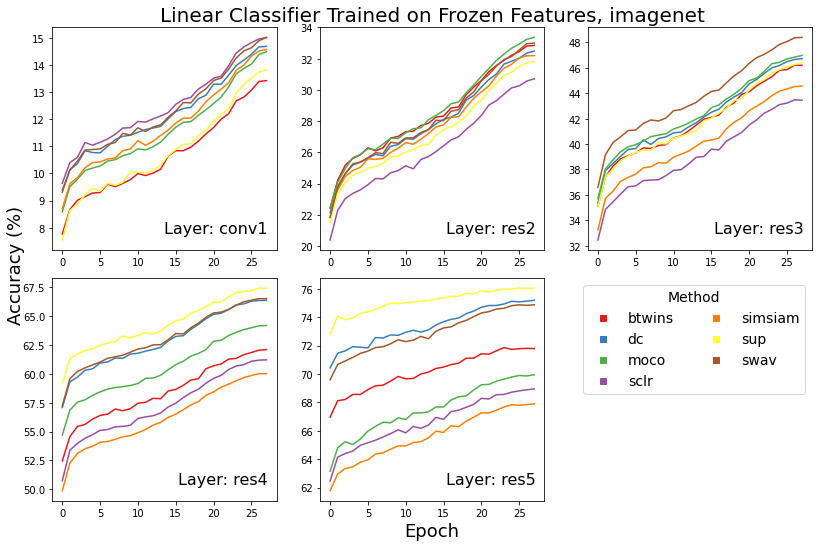

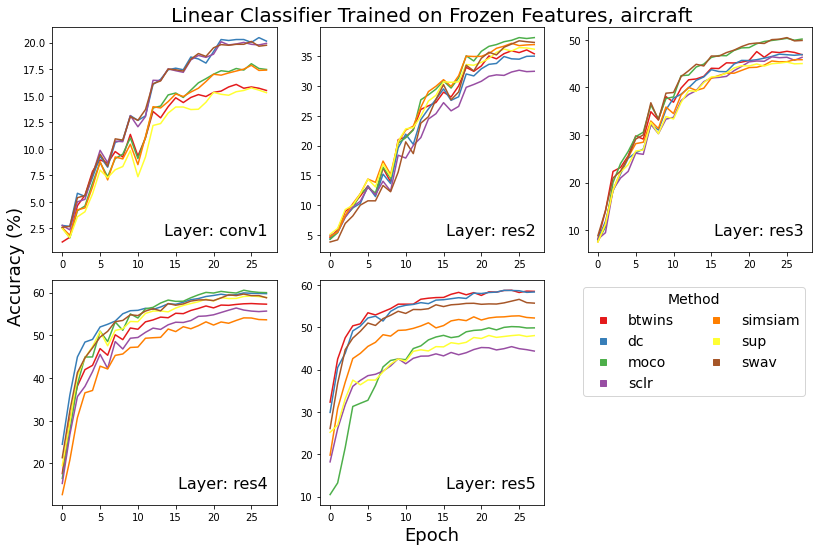

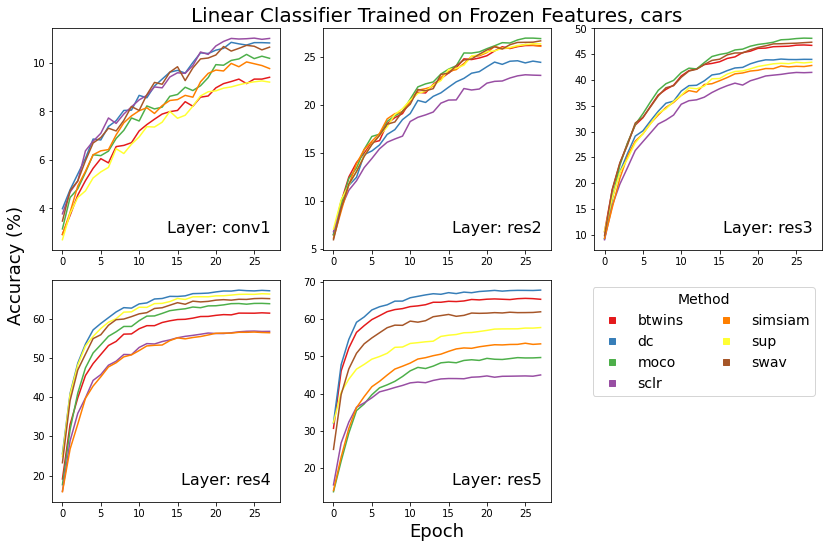

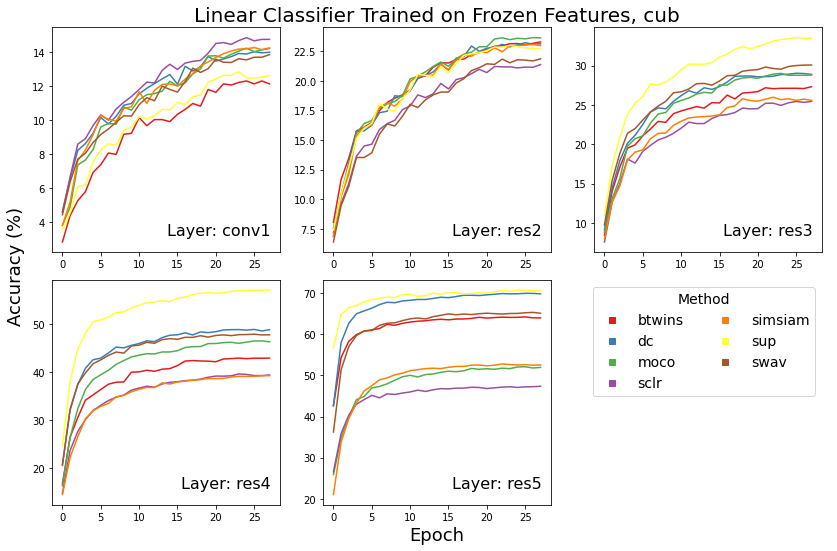

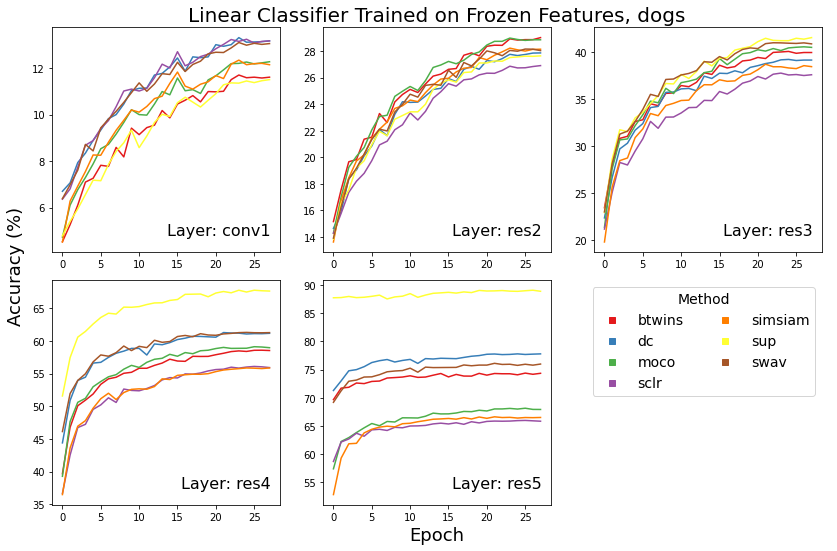

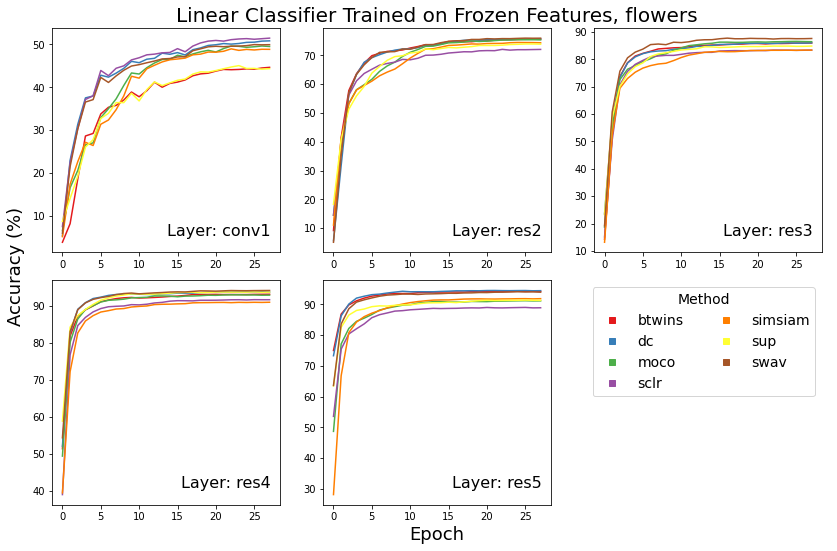

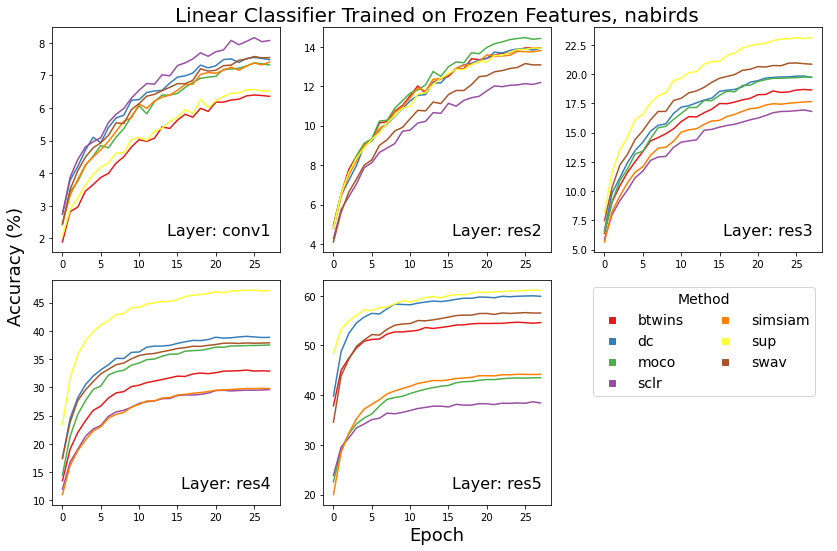

In [17]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
cmap = plt.get_cmap('Set1')
colormap = np.array(list(cmap.colors))

method_names = ['btwins', 'dc', 'moco', 'sclr', 'simsiam', 'sup', 'swav']
#method_names = ['btwins', 'moco', 'sclr', 'simsiam', 'sup', 'swav']
vissl_dir = '/vulcanscratch/mgwillia/vissl'
for dataset in ['imagenet', 'aircraft', 'cars', 'cub', 'dogs', 'flowers', 'nabirds']:
    ## TODO: eventually, compare top-1 to top-5
    results = {}
    for results_folder in os.listdir(vissl_dir):
        if f'chkpts_b_{dataset}' not in results_folder:
            continue
        if 'metrics.json' not in os.listdir(os.path.join(vissl_dir, results_folder)):
            continue
        method_name = results_folder.split('_')[3]
        if len(results_folder.split('_')) == 4:
            idx = 0
        else:
            continue
            #idx = int(results_folder.split('_')[4])
        if method_name not in results:
            results[method_name] = {
                'train': {},
                'val': {}
            }
        #print(os.path.join(vissl_dir, results_folder, 'metrics.json'))
        with open(os.path.join(vissl_dir, results_folder, 'metrics.json'), 'r') as read_file:
            for line in read_file.readlines():
                json_line = json.loads(line)
                if 'train_accuracy_list_meter' in json_line.keys():
                    for key, value in json_line['train_accuracy_list_meter']['top_1'].items():
                        if key not in results[method_name]['train']:
                            results[method_name]['train'][key] = []
                            #results[method_name]['train'][key] = [[],[],[]]
                        results[method_name]['train'][key].append(value)
                        #results[method_name]['train'][key][idx].append(value)
                elif 'test_accuracy_list_meter' in json_line.keys():
                    for key, value in json_line['test_accuracy_list_meter']['top_1'].items():
                        if key not in results[method_name]['val']:
                            results[method_name]['val'][key] = []
                            #results[method_name]['val'][key] = [[],[],[]]
                        results[method_name]['val'][key].append(value)
                        #results[method_name]['val'][key][idx].append(value)

    fig, axs = plt.subplots(2, 3)
    for i, layer_name in enumerate(['conv1', 'res2', 'res3', 'res4', 'res5']):
        for j, method_name in enumerate(method_names):
            accuracies = results[method_name]['val'][layer_name]
            #accuracies_arr = np.array(accuracies)
            #axs[int(i/3), int(i%3)].plot(accuracies_arr.mean(axis=0), c=colormap[j])
            axs[int(i/3), int(i%3)].plot(accuracies, c=colormap[j])
            axs[int(i/3), int(i%3)].legend([], [], title=f'Layer: {layer_name}', title_fontsize=16, loc='lower right', frameon=False)

    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    handles = [f("s", colormap[i]) for i in range(7)]
    axs[1,2].legend(handles,
              method_names,
              title='Method',
              title_fontsize=14,
              scatterpoints=1,
              ncol=2,
              fontsize=14)
    axs[1,2].axis('off')
    axs[1,2].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.title(f'Linear Classifier Trained on Frozen Features, {dataset}', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy (%)', fontsize=18)

    fig.tight_layout()
    plt.savefig(f'{dataset}_frozen_results', bbox_inches = 'tight',
        pad_inches = 0.1)

In [16]:
### MAKE LIN EVAL TABLE ###
method_names = ['sclr100', 'sclr200', 'sclr400', 'sclr', 'sclr1000']

method_table_results = {}
for dataset_name, dataset_results in results.items():
    for method_name in method_names:
        method_results = dataset_results[method_name]
        if method_name not in method_table_results:
            method_table_results[method_name] = {}
        method_table_results[method_name][dataset_name.lower()] = method_results['val'][layer_name][-1]
        
datasets = ['ImageNet', 'Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds']
method_print_name = {
    'sclr100': '100 Epochs',
    'sclr200': '200 Epochs',
    'sclr400': '400 Epochs',
    'sclr': '800 Epochs',
    'sclr1000': '1000 Epochs'
}

print('\\begin{tabular}{l l l l l l l l}')
print('\\multirow{2}{*}{Method} & \\multicolumn{7}{c}{Dataset} \\\\ \\cmidrule{2-8}')
print('{} & \\multicolumn{1}{c}{' + '} & \\multicolumn{1}{c}{'.join(datasets) + '} \\\\')
print('\\midrule')
for method_name, method_results in method_table_results.items():
    accs = []
    for dataset_name in datasets:
        accs.append(f'{method_results[dataset_name.lower()]:.2f}')
    print(f'\t{method_print_name[method_name.split("_")[0]]} & {" & ".join(accs)} \\\\')
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{l l l l l l l l}
\multirow{2}{*}{Method} & \multicolumn{7}{c}{Dataset} \\ \cmidrule{2-8}
{} & \multicolumn{1}{c}{ImageNet} & \multicolumn{1}{c}{Aircraft} & \multicolumn{1}{c}{Cars} & \multicolumn{1}{c}{CUB} & \multicolumn{1}{c}{Dogs} & \multicolumn{1}{c}{Flowers} & \multicolumn{1}{c}{NABirds} \\
\midrule
	100 Epochs & 64.76 & 44.81 & 44.67 & 43.17 & 60.44 & 88.72 & 34.34 \\
	200 Epochs & 66.92 & 45.56 & 46.31 & 46.05 & 62.48 & 89.39 & 36.90 \\
	400 Epochs & 67.93 & 44.84 & 46.36 & 46.00 & 64.35 & 89.08 & 37.23 \\
	800 Epochs & 68.95 & 44.39 & 45.00 & 47.36 & 65.84 & 88.90 & 38.43 \\
	1000 Epochs & 64.57 & 45.26 & 44.55 & 46.93 & 66.25 & 88.57 & 37.93 \\
\bottomrule
\end{tabular}
